In [1]:
import pandas as pd
import seaborn as sns
import os
import numpy as np
import matplotlib.pyplot as plt
from pyprojroot.here import here
import anndata as ad

In [2]:
def return_dfs(n_genes):
    all_dfs = [pd.read_csv(here(f'03_downstream_analysis/08_gene_importance/xgboost_external_validation/xgboost_TopN_genes/results_{n_genes}/metrics/{fpath}'), index_col=0) for fpath in os.listdir(f'results_{n_genes}/metrics')]
    all_dfs = pd.concat(all_dfs)
    all_dfs = all_dfs.assign(setting=[s if s in ['shap', 'all'] else 'rand' for s in all_dfs.gene_set_seed])
    data = all_dfs.groupby(['gene_set_seed', 'cell_type']).agg({'BAS':'mean', 'WF1':'mean','setting':'first'})
    BAS_ms = data.reset_index().groupby(['cell_type', 'setting']).BAS.agg(['mean','std']).fillna(0)
    WF1_ms = data.reset_index().groupby(['cell_type', 'setting']).WF1.agg(['mean','std']).fillna(0)
    all_ms = BAS_ms.merge(WF1_ms, right_index=True, left_index=True, suffixes=('_BAS', '_WF1')).reset_index()

    return data, all_ms

In [3]:
data_5, all_ms_5 = return_dfs(5)
data_10, all_ms_10 = return_dfs(10)

In [4]:
celltype_renamimg = {
    'B': 'B',
    'Plasma': 'Plasma',
    'pDC': 'pDC',
    'DC': 'DC',
    'Mono': 'Mono',
    'T_CD4_Naive': 'CD4 Naive',
    'T_CD4_NonNaive': 'CD4 Non-Naive',
    'T_CD8_Naive': 'CD8 Naive',
    'T_CD8_NonNaive': 'CD8 Non-Naive',
    'UTC': 'UTC',
    'ILC': 'ILC',
}

In [5]:
stats_5 = pd.read_csv(here('03_downstream_analysis/08_gene_importance/xgboost_external_validation/shap_gene_selection/sel_percent_5.csv'))
stats_5.columns = ['cell_type', 'stats']

stats_10 = pd.read_csv(here('03_downstream_analysis/08_gene_importance/xgboost_external_validation/shap_gene_selection/sel_percent_10.csv'))
stats_10.columns = ['cell_type', 'stats']

In [6]:
data_5.reset_index().query('setting == "rand"').assign(selection='top_5').drop(columns=['gene_set_seed', 'BAS', 'setting'])

,cell_type,WF1,selection
0,B,0.633472,top_5
1,DC,0.705439,top_5
2,ILC,0.542222,top_5
3,Mono,0.674577,top_5
4,Plasma,0.352001,top_5
...,...,...,...
215,T_CD4_NonNaive,0.676466,top_5
216,T_CD8_Naive,0.646187,top_5
217,T_CD8_NonNaive,0.664054,top_5
218,UTC,0.619573,top_5


In [7]:
data_5.reset_index().query('setting == "rand"').assign(selection='top_5').drop(columns=['gene_set_seed', 'BAS', 'setting'])

,cell_type,WF1,selection
0,B,0.633472,top_5
1,DC,0.705439,top_5
2,ILC,0.542222,top_5
3,Mono,0.674577,top_5
4,Plasma,0.352001,top_5
...,...,...,...
215,T_CD4_NonNaive,0.676466,top_5
216,T_CD8_Naive,0.646187,top_5
217,T_CD8_NonNaive,0.664054,top_5
218,UTC,0.619573,top_5


In [8]:
n_genes_ls = []
for cell_type in celltype_renamimg.keys():
    adata = ad.read_h5ad(here(f'inflammabucket_bkp/03_downstream_analysis/05_SHAP/data/{cell_type}_adataMerged_SPECTRAgenes.log1p.h5ad'), backed='r')
    symbols_df = pd.read_pickle(here('inflammabucket_bkp/03_downstream_analysis/04_selected_gene_list.pkl'))
    symbols_sorted = symbols_df.loc[adata.var_names].symbol.values
    perc_gene_expr = pd.read_csv(here('inflammabucket_bkp/03_downstream_analysis/05_SHAP/data/genes_expressing_cells.csv'))
    perc_gene_expr = perc_gene_expr.astype({'symbol': 'str', '% cells': 'float', 'CellType': 'category'})
    well_expressed_symbols = perc_gene_expr.query('`% cells` > 5 & CellType == @cell_type').symbol
    symbol_mask = symbols_sorted.isin(well_expressed_symbols)
    symbols_sorted = symbols_sorted[symbol_mask]

    n_genes_5 = len(np.load(here(f'03_downstream_analysis/08_gene_importance/xgboost_external_validation/shap_gene_selection/gene_subsets_5/{cell_type}_shap.npy'), allow_pickle=True))
    n_genes_10 = len(np.load(here(f'03_downstream_analysis/08_gene_importance/xgboost_external_validation/shap_gene_selection/gene_subsets_10/{cell_type}_shap.npy'), allow_pickle=True))

    n_genes_ls.extend([("top_5", n_genes_5, cell_type), ("top_10", n_genes_10, cell_type), ("all", len(symbols_sorted), cell_type)])

In [9]:
n_genes_df = pd.DataFrame(n_genes_ls, columns=['selection', 'n_genes', 'cell_type']).replace(celltype_renamimg).replace(dict(top_5='Random Selection [Top 5 genes]', top_10='Random Selection [Top 10 genes]', all='No selection'))
n_genes_df.head()

,selection,n_genes,cell_type
0,Random Selection [Top 5 genes],29,B
1,Random Selection [Top 10 genes],55,B
2,No selection,466,B
3,Random Selection [Top 5 genes],30,Plasma
4,Random Selection [Top 10 genes],54,Plasma


In [10]:
data_5.reset_index().gene_set_seed.unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 'all', 'shap'], dtype=object)

In [11]:
pdata_WF1 = pd.concat([
    data_5.reset_index().query('setting == "rand"').assign(selection='top_5',shap=False).drop(columns=['gene_set_seed', 'BAS', 'setting']).rename(columns={'WF1':'value'}),
    data_10.reset_index().query('setting == "rand"').assign(selection='top_10',shap=False).drop(columns=['gene_set_seed', 'BAS', 'setting']).rename(columns={'WF1':'value'}),
    all_ms_5.query('setting == "all"').rename(columns={'mean_WF1':'value'}).drop(columns=['setting', 'mean_BAS', 'std_BAS', 'std_WF1']).assign(selection='all',shap=True),
    all_ms_5.query('setting == "shap"').rename(columns={'mean_WF1':'value'}).drop(columns=['setting', 'mean_BAS', 'std_BAS', 'std_WF1']).assign(selection='top_5',shap=True),
    all_ms_10.query('setting == "shap"').rename(columns={'mean_WF1':'value'}).drop(columns=['setting', 'mean_BAS', 'std_BAS', 'std_WF1']).assign(selection='top_10',shap=True)
]).assign(metric='WF1')

In [12]:
pdata_BAS = pd.concat([
    data_5.reset_index().query('setting == "rand"').assign(selection='top_5',shap=False).drop(columns=['gene_set_seed', 'WF1', 'setting']).rename(columns={'BAS':'value'}),
    data_10.reset_index().query('setting == "rand"').assign(selection='top_10',shap=False).drop(columns=['gene_set_seed', 'WF1', 'setting']).rename(columns={'BAS':'value'}),
    all_ms_5.query('setting == "all"').rename(columns={'mean_BAS':'value'}).drop(columns=['setting', 'mean_WF1', 'std_BAS', 'std_WF1']).assign(selection='all',shap=True),
    all_ms_5.query('setting == "shap"').rename(columns={'mean_BAS':'value'}).drop(columns=['setting', 'mean_WF1', 'std_BAS', 'std_WF1']).assign(selection='top_5',shap=True),
    all_ms_10.query('setting == "shap"').rename(columns={'mean_BAS':'value'}).drop(columns=['setting', 'mean_WF1', 'std_BAS', 'std_WF1']).assign(selection='top_10',shap=True)
]).assign(metric='BAS')

In [13]:
pdata = pd.concat((pdata_WF1, pdata_BAS)).replace(celltype_renamimg).replace(dict(top_5='Random Selection [Top 5 genes]', top_10='Random Selection [Top 10 genes]', all='No selection'))
pdata

,cell_type,value,selection,shap,metric
0,B,0.633472,Random Selection [Top 5 genes],False,WF1
1,DC,0.705439,Random Selection [Top 5 genes],False,WF1
2,ILC,0.542222,Random Selection [Top 5 genes],False,WF1
3,Mono,0.674577,Random Selection [Top 5 genes],False,WF1
4,Plasma,0.352001,Random Selection [Top 5 genes],False,WF1
...,...,...,...,...,...
20,CD4 Non-Naive,0.644711,Random Selection [Top 10 genes],True,BAS
23,CD8 Naive,0.641869,Random Selection [Top 10 genes],True,BAS
26,CD8 Non-Naive,0.610937,Random Selection [Top 10 genes],True,BAS
29,UTC,0.512402,Random Selection [Top 10 genes],True,BAS


/scratch_isilon/groups/singlecell/shared/conda_env/plotting/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  self._figure.tight_layout(*args, **kwargs)


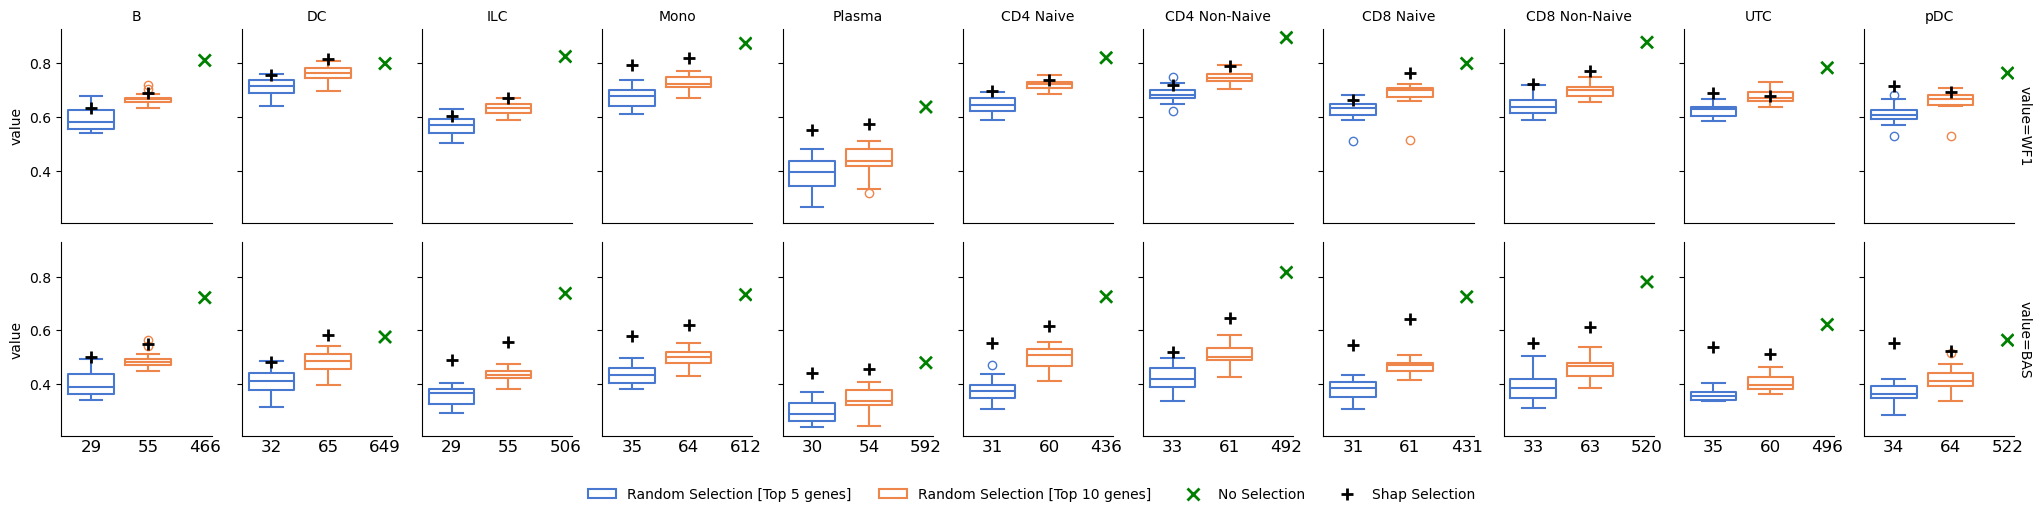

In [16]:
g = sns.FacetGrid(pdata, col="cell_type", row="metric", height=2.5, aspect=.8, margin_titles=True)

def barplot(data, x, y, hue, **kwargs):
    data = data.query('not shap')
    ax = sns.boxplot(x=x, y=y, hue=hue, data=data, legend=True, palette='muted', fill=False)
    current_celltype = data.cell_type.iloc[0]
    if data.metric.iloc[0] == 'BAS':
        for index, row in n_genes_df.query('cell_type == @current_celltype').iterrows():
            ax.text(row[x], 0.15, row['n_genes'], color='black', ha="center",size=12)
g.map_dataframe(barplot, x='selection', y='value', hue='selection')

def scatterplot(data, x, y, hue, **kwargs):
    data = data.query('shap').assign(nos=lambda df: ["No Selection" if x == "No selection" else "Shap Selection" for x in df.selection])
    ax = sns.scatterplot(x=x, y=y, hue='nos', style='nos',palette=["green", "black"], markers=["x","+"], linewidth=2, s=75, data=data, legend=True, zorder=100)
g.map_dataframe(scatterplot, x='selection', y='value', hue='selection')

g.set_titles(col_template='{col_name}',row_template='value={row_name}')
g.set(xticks=[],xlabel=None)
g.figure.subplots_adjust(wspace=.2, hspace=0.1)
g.add_legend(bbox_to_anchor=(0.5, 0), ncols=4)

plt.savefig("performance_shap_selection.svg", dpi=400, bbox_inches='tight')